# Extension

## 1) Data preparation

###  A) Load datasets

First we will load all the dataset we need. We load the 2015 ward Tesco 1.0 dataset and the official London ward 2015 dataset.

In [1]:
import os
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

In [2]:
root = "data/"
tesco_msoa_path = os.path.join(root,"year_msoa_grocery.csv")
msoa_profile_path = os.path.join(root,"msoa-data.csv")

In [3]:
tesco_msoa_df = pd.read_csv(tesco_msoa_path)
msoa_profile_df = pd.read_csv(msoa_profile_path,encoding = "ISO-8859-1")

In [4]:
tesco_msoa_df.head(5)

,area_id,weight,weight_perc2.5,weight_perc25,weight_perc50,weight_perc75,weight_perc97.5,weight_std,weight_ci95,volume,...,man_day,population,male,female,age_0_17,age_18_64,age_65+,avg_age,area_sq_km,people_per_sq_km
0,E02000001,323.180804,35.0,150.0,250.0,400.0,1000.0,323.685705,1.001360,98.849228,...,103934,6687.0,3697.0,2990.0,1018.0,4349.0,1320.0,43.910124,2.90,2305.862069
1,E02000002,397.651232,32.5,150.0,300.0,500.0,1020.0,550.434424,6.030232,118.288417,...,9952,7379.0,3549.0,3830.0,2150.0,4151.0,1078.0,35.567286,2.16,3416.203704
2,E02000003,371.276702,30.0,140.0,250.0,450.0,1200.0,564.404826,4.398728,118.385615,...,19576,10720.0,5297.0,5423.0,2762.0,6649.0,1309.0,35.700466,2.14,5009.345794
3,E02000004,347.481292,29.0,126.0,250.0,430.0,1000.0,479.372575,5.297349,104.435407,...,10689,6536.0,3119.0,3417.0,1454.0,4044.0,1038.0,38.493115,2.48,2635.483871
4,E02000005,400.576688,32.5,150.0,296.0,500.0,1050.0,593.021809,5.107669,128.997438,...,15071,9243.0,4478.0,4765.0,2678.0,5554.0,1011.0,34.156335,1.19,7767.226891


In [5]:
tesco_msoa_df.shape

(983, 202)

In paper dataset, we have 201 nutrition related features and 983 msoa areas.

In [6]:
msoa_profile_df.head(2)

,Middle Super Output Area,MSOA Name,Age Structure (2011 Census);All Ages;,Age Structure (2011 Census);0-15;,Age Structure (2011 Census);16-29;,Age Structure (2011 Census);30-44;,Age Structure (2011 Census);45-64;,Age Structure (2011 Census);65+;,Age Structure (2011 Census);Working-age;,Mid-year Estimate totals;All Ages;2002,...,Road Casualties;2010;Slight,Road Casualties;2010;2010 Total,Road Casualties;2011;Fatal,Road Casualties;2011;Serious,Road Casualties;2011;Slight,Road Casualties;2011;2011 Total,Road Casualties;2012;Fatal,Road Casualties;2012;Serious,Road Casualties;2012;Slight,Road Casualties;2012;2012 Total
0,E02000001,City of London 001,7375,620,1665,2045,2010,1035,5720,7280,...,334,374,0,46,359,405,2,51,361,414
1,E02000002,Barking and Dagenham 001,6775,1751,1277,1388,1258,1101,3923,6333,...,18,18,0,2,16,18,0,1,15,16


In [7]:
msoa_profile_df.shape

(984, 207)

In official ward dataset, we have 207 different features about official statistics of each ward. We observe there are 984 msoa areas.

Now we will load geographic data of wards for geovisualization.

In [8]:
msoa_map_path = os.path.join(root,"London","ESRI","MSOA_2011_London_gen_MHW.shp")
msoa_map_df = gpd.read_file(msoa_map_path)
msoa_map_df.head(5)

,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM,RGN11CD,RGN11NM,USUALRES,HHOLDRES,COMESTRES,POPDEN,HHOLDS,AVHHOLDSZ,geometry
0,E02000001,City of London 001,E09000001,City of London,E12000007,London,7375,7187,188,25.5,4385,1.6,"MULTIPOLYGON (((531667.624 180534.992, 531647...."
1,E02000002,Barking and Dagenham 001,E09000002,Barking and Dagenham,E12000007,London,6775,6724,51,31.3,2713,2.5,"POLYGON ((548881.563 190845.265, 548881.125 19..."
2,E02000003,Barking and Dagenham 002,E09000002,Barking and Dagenham,E12000007,London,10045,10033,12,46.9,3834,2.6,"POLYGON ((549102.438 189324.625, 548954.500 18..."
3,E02000004,Barking and Dagenham 003,E09000002,Barking and Dagenham,E12000007,London,6182,5937,245,24.8,2318,2.6,"POLYGON ((551549.998 187364.637, 551478.000 18..."
4,E02000005,Barking and Dagenham 004,E09000002,Barking and Dagenham,E12000007,London,8562,8562,0,72.1,3183,2.7,"POLYGON ((549099.634 187656.076, 549161.375 18..."


In [9]:
msoa_map_df.shape

(983, 13)

This dataset presents the localization of 983 msoa areas.

<AxesSubplot:>

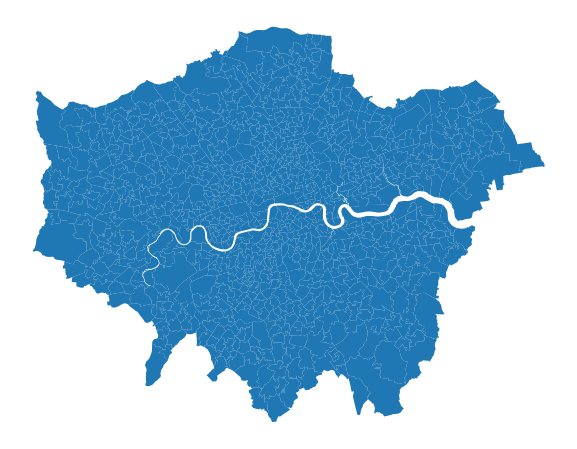

In [10]:
fig, ax = plt.subplots(1, figsize=(12, 8))
ax.axis("off")
msoa_map_df.plot(ax=ax)

### B) Prepare datasets

We choose the median because it has a better representativeness than the mean.

In [11]:
official_useful_features = ["Household Income Estimates (2011/12);Total Median Annual Household Income (£);",
                            "Middle Super Output Area"]
main_df = tesco_msoa_df.merge(msoa_profile_df[official_useful_features],
                              left_on="area_id",right_on="Middle Super Output Area")
main_df = main_df.rename(columns={"Household Income Estimates (2011/12);Total Median Annual Household Income (£);":
               "median_income"}).drop(columns=["Middle Super Output Area"])
main_df.head(5)

,area_id,weight,weight_perc2.5,weight_perc25,weight_perc50,weight_perc75,weight_perc97.5,weight_std,weight_ci95,volume,...,population,male,female,age_0_17,age_18_64,age_65+,avg_age,area_sq_km,people_per_sq_km,median_income
0,E02000001,323.180804,35.0,150.0,250.0,400.0,1000.0,323.685705,1.001360,98.849228,...,6687.0,3697.0,2990.0,1018.0,4349.0,1320.0,43.910124,2.90,2305.862069,46788
1,E02000002,397.651232,32.5,150.0,300.0,500.0,1020.0,550.434424,6.030232,118.288417,...,7379.0,3549.0,3830.0,2150.0,4151.0,1078.0,35.567286,2.16,3416.203704,27059
2,E02000003,371.276702,30.0,140.0,250.0,450.0,1200.0,564.404826,4.398728,118.385615,...,10720.0,5297.0,5423.0,2762.0,6649.0,1309.0,35.700466,2.14,5009.345794,36835
3,E02000004,347.481292,29.0,126.0,250.0,430.0,1000.0,479.372575,5.297349,104.435407,...,6536.0,3119.0,3417.0,1454.0,4044.0,1038.0,38.493115,2.48,2635.483871,39668
4,E02000005,400.576688,32.5,150.0,296.0,500.0,1050.0,593.021809,5.107669,128.997438,...,9243.0,4478.0,4765.0,2678.0,5554.0,1011.0,34.156335,1.19,7767.226891,29156


#### Similarly as done in the Tesco paper, let's filter the msoa that have representativeness norm lesser than a threhold = 0.1

In [12]:
repr_msoa_df = main_df[ main_df['representativeness_norm'] >= 0.1 ]

In [13]:
ini_data_size = main_df.shape[0]
repr_data_size = repr_msoa_df.shape[0]
prop = (ini_data_size-repr_data_size)/ini_data_size
print('With the chosen threshold we drop {:.2f}% of the msoa data'.format(prop*100))

With the chosen threshold we drop 9.87% of the msoa data


### C) Cluster income levels using K-means

In [14]:
income_repr_msoa_df = repr_msoa_df[['area_id','median_income']]
income_repr_msoa_df_sorted = income_repr_msoa_df.sort_values(by='median_income').reset_index(drop=True)
income_repr_msoa_df_sorted.head(10)

,area_id,median_income
0,E02000373,17878
1,E02000398,17955
2,E02000306,18308
3,E02006794,18362
4,E02000408,18993
5,E02000577,19212
6,E02000049,19305
7,E02006793,19714
8,E02000402,19793
9,E02000282,19940


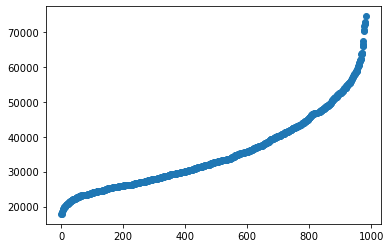

In [15]:
plt.scatter(income_repr_msoa_df.index, income_repr_msoa_df_sorted['median_income'])
plt.show()

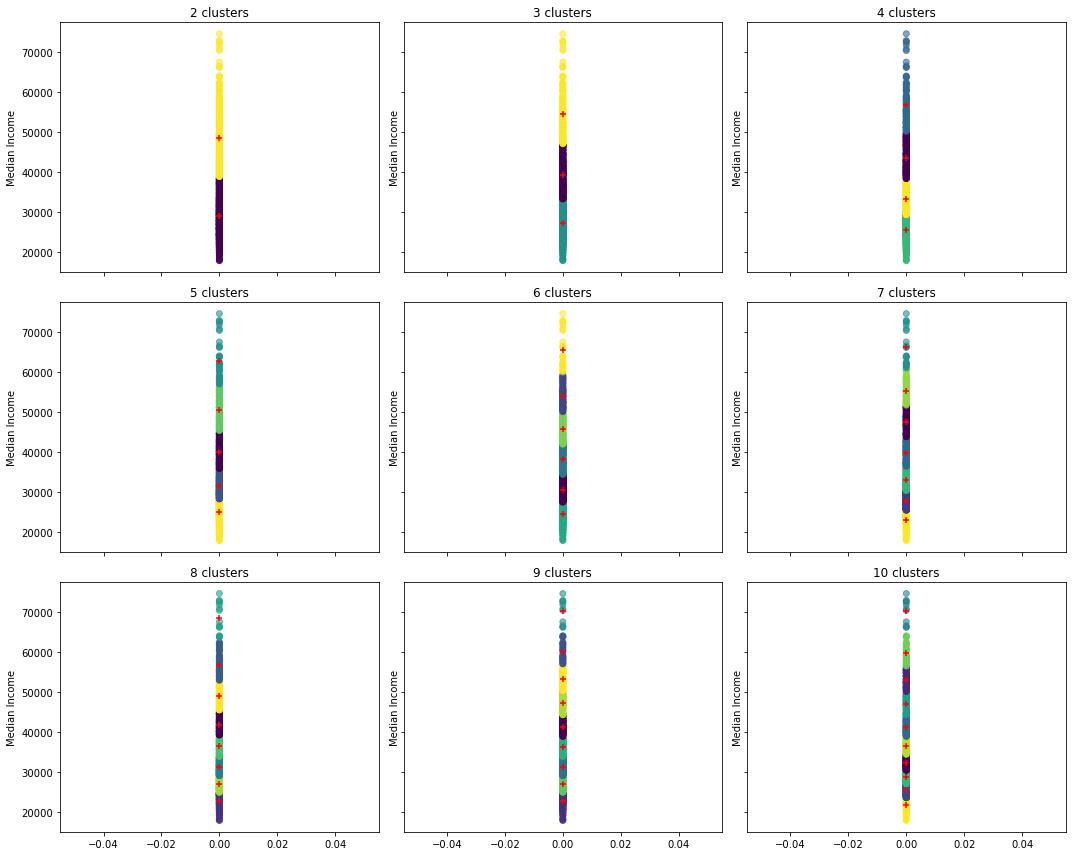

In [16]:
from sklearn.cluster import KMeans
import math

MIN_CLUSTERS = 2
MAX_CLUSTERS = 10

median_income = np.array(income_repr_msoa_df_sorted['median_income']).reshape(-1, 1)
x = np.zeros(median_income.shape[0])

# Compute number of row and columns
COLUMNS = 3
ROWS = math.ceil((MAX_CLUSTERS-MIN_CLUSTERS)/COLUMNS)
fig, axs = plt.subplots(ROWS, COLUMNS, figsize=(15,12), sharey=True, sharex=True)

# Plot the clusters
for n_clusters in range(MIN_CLUSTERS, MAX_CLUSTERS+1):
    current_column = (n_clusters-MIN_CLUSTERS)%COLUMNS
    current_row = (n_clusters-MIN_CLUSTERS)//COLUMNS
    
    # Get the axis where to add the plot
    ax = axs[current_row, current_column]
    
    # Cluster the data with the current number of clusters
    kmean = KMeans(n_clusters=n_clusters, random_state=42).fit(median_income)
    
    # Plot the data by using the labels as color
    ax.scatter(x, median_income, c=kmean.labels_, alpha=0.6)
    ax.set_title("%s clusters"%n_clusters)
    ax.set_ylabel("Median Income")
    
    # Plot the centroids
    for c in kmean.cluster_centers_:
        ax.scatter(0, c, marker="+", color="red")
        
plt.tight_layout()

5 clusters seems to separate the data fairly well and we add the following labels:  
Median income = {0=`very_low`, 1=`low`, 2=`medium`, 3=`high`, 4=`very_high`}

In [17]:
wealth_class_labels = ['very_low', 'low', 'medium', 'high', 'very_high']
CHOSEN_CLUSTER_NB = 5

# Run k-means with the chosen number of clusters
data = np.array(income_repr_msoa_df['median_income']).reshape(-1, 1)
kmean = KMeans(n_clusters=CHOSEN_CLUSTER_NB).fit(data)

# Since the method does not return the labels sorted by increasing median_come we need to map them correctly
# Transforming the labels through a lookup table is a straightforward way to sort kmeans' labels
idx = np.argsort(kmean.cluster_centers_.sum(axis=1))
lut = np.zeros_like(idx)
lut[idx] = np.arange(CHOSEN_CLUSTER_NB)
labels = lut[kmean.labels_]

cluster_map = pd.DataFrame()
cluster_map['area_id'] = income_repr_msoa_df['area_id']
cluster_map['median_income'] = income_repr_msoa_df['median_income']
cluster_map['wealth_class'] = labels

print(kmean.cluster_centers_)
cluster_map.head()

[[31589.59448819]
 [50474.12096774]
 [40140.3027027 ]
 [24906.59929078]
 [62749.02439024]]


,area_id,median_income,wealth_class
0,E02000001,46788,3
1,E02000002,27059,0
2,E02000003,36835,2
3,E02000004,39668,2
4,E02000005,29156,1


In [18]:
main_df = repr_msoa_df.merge(cluster_map[['area_id', 'wealth_class']],
                              left_on="area_id",right_on="area_id")
main_df.head(5)

,area_id,weight,weight_perc2.5,weight_perc25,weight_perc50,weight_perc75,weight_perc97.5,weight_std,weight_ci95,volume,...,male,female,age_0_17,age_18_64,age_65+,avg_age,area_sq_km,people_per_sq_km,median_income,wealth_class
0,E02000001,323.180804,35.0,150.0,250.0,400.0,1000.0,323.685705,1.001360,98.849228,...,3697.0,2990.0,1018.0,4349.0,1320.0,43.910124,2.90,2305.862069,46788,3
1,E02000002,397.651232,32.5,150.0,300.0,500.0,1020.0,550.434424,6.030232,118.288417,...,3549.0,3830.0,2150.0,4151.0,1078.0,35.567286,2.16,3416.203704,27059,0
2,E02000003,371.276702,30.0,140.0,250.0,450.0,1200.0,564.404826,4.398728,118.385615,...,5297.0,5423.0,2762.0,6649.0,1309.0,35.700466,2.14,5009.345794,36835,2
3,E02000004,347.481292,29.0,126.0,250.0,430.0,1000.0,479.372575,5.297349,104.435407,...,3119.0,3417.0,1454.0,4044.0,1038.0,38.493115,2.48,2635.483871,39668,2
4,E02000005,400.576688,32.5,150.0,296.0,500.0,1050.0,593.021809,5.107669,128.997438,...,4478.0,4765.0,2678.0,5554.0,1011.0,34.156335,1.19,7767.226891,29156,1


## 2) Visualization

### A) T-SNE visualization

In [19]:
from sklearn.manifold import TSNE

We set the vector of energy distribution between nutrients as first feature for each area.

In [20]:
features=["f_energy_fat","f_energy_fibre","f_energy_protein",
          "f_energy_sugar","f_energy_alcohol","f_energy_alcohol"]

In [21]:
tsne_nutrients = TSNE(n_components=2).fit_transform(main_df[features])

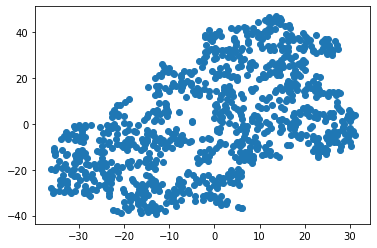

In [22]:
plt.scatter(tsne_nutrients[:,0],tsne_nutrients[:,1])

We don't observe clear difference in eating habits between MSOAs. Let's try with another feature, the distribution of dishes bought by the customers.

In [23]:
feats = []
for col in main_df.columns:
    if "f_" in col and "energy" not in col:
        feats.append(col)
len(feats)

28

In [24]:
tsne_dishes = TSNE(n_components=2).fit_transform(main_df[feats])

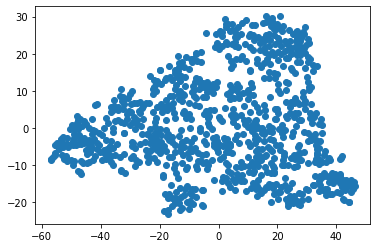

In [25]:
plt.scatter(tsne_dishes[:,0],tsne_dishes[:,1])

### B) London choropleth map

First we will visualize the fraction of each nutrient at msoa level. Let's define a function to output a choropleth map.

In [26]:
def london_vis(geo_map, data_df, ax, variable, geo_map_index="MSOA11CD", data_df_index="area_id"):
    merged_df = geo_map.merge(data_df,left_on=geo_map_index,right_on=data_df_index, how="left")
    merged_df.plot(ax=ax,column=variable, cmap='Blues',linewidth=0.2,edgecolor='0.8',legend=True)
    ax.annotate('Source: London Datastore, 2014 and Tesco 1.0 dataset',xy=(0.1, .08),  
                xycoords='figure fraction', horizontalalignment='left', 
                verticalalignment='top', fontsize=12, color='#555555')
    ax.set_title("Comparison of {:s} between each MSOA of Greater London".format(variable))

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

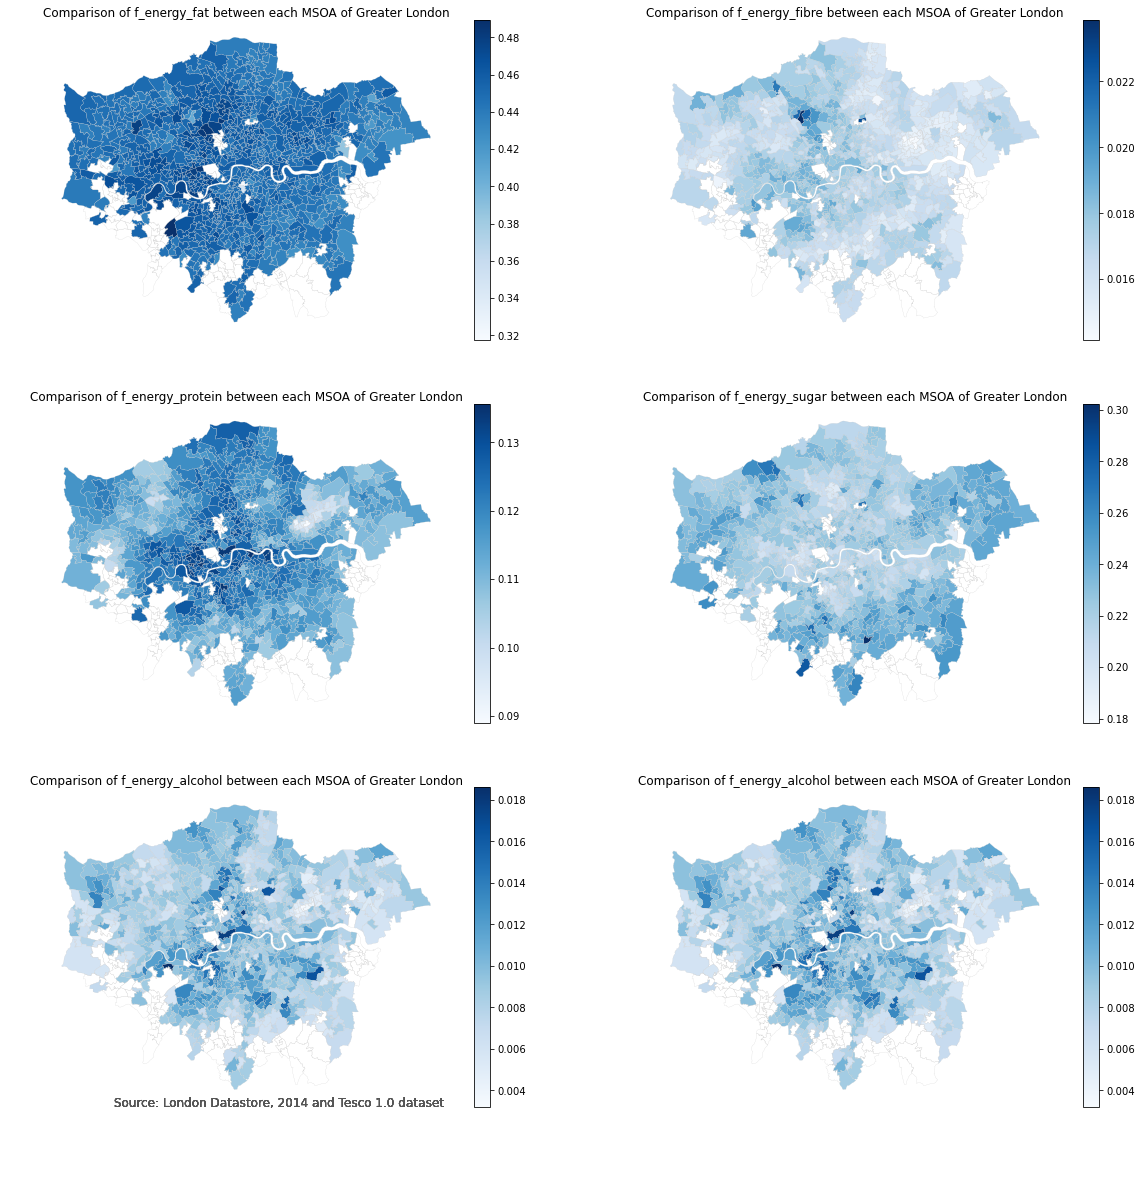

In [27]:
fig, ax = plt.subplots(3,2, figsize=(20,20))

for ax_,feat in zip(ax.reshape(-1), features):
    df_feats = ["area_id"]+[feat]
    london_vis(msoa_map_df, main_df[df_feats],ax_,feat)
    ax_.axis("off")
plt.plot